## Plot all traces of ROMY array

### Import

In [13]:
import obspy as obs
import numpy as np
import matplotlib.pyplot as plt

from time import sleep

from numpy import isnan, ones, nan
from andbro__querrySeismoData import __querrySeismoData
from andbro__get_timeaxis import __get_timeaxis

import warnings
warnings.filterwarnings("ignore")

### Methods

In [14]:
def __get_stream(config):
    st = obs.Stream()

    for i in range(len(config.get("sta"))):

        seed = f'{config.get("net")[i]}.{config.get("sta")[i]}.{config.get("loc")}.{config.get("cha")}'

        print(f"loading {seed}...")
        count = 3
        while count != 0: 
            try:

                st0, inv = __querrySeismoData(  
                                            seed_id=seed,
                                            starttime=config.get("tbeg"),
                                            endtime=config.get("tend"),
                                            where=config.get("repository"),
                                            path=None,
                                            restitute=True,
                                            detail=None,
                                            fill_value=None,
                                            )

                if len(st0) != 0:
                    st += st0
                count = 0
            except: 
                count -= 1
                print("  -> Failed!")
    return st

In [15]:
def __empty_trace(config, i):
    tr = obs.Trace()
    tr.stats.sampling_rate = 20
    tr.data = np.zeros(int((config['tend']-config['tbeg'])*tr.stats.sampling_rate)+1) * np.nan
    tr.stats.station = config['sta'][i]
    tr.stats.network = config['net'][i]
    tr.stats.channel = config['cha']
    tr.stats.starttime = config['tbeg']
    
    return tr

In [16]:
def __makeplot_array_traces(st, config):
    
    N = len(config['sta'])

    fig, axes = plt.subplots(N, 1, figsize=(15,20), sharex='col')

    plt.subplots_adjust(hspace=0.2,wspace=0.2)
    
    for i, sta in enumerate(config['sta']):
        
        try:
            tr = st.select(station=sta)[0]
        except:
            tr = __empty_trace(config, i)
        
        print(f' plotting {tr.stats.station} ...')
        try:
            timeaxis, ticks, ticklabels, text = __get_timeaxis(
                                                             utcdatetime=tr.times(type="utcdatetime"),
                                                             unit="time",
                                                             unitmode="absolute",
                                                             dateformat="yyyymmdd",
                                                              )
        
            sta_cha = f"{tr.stats.station}.{tr.stats.channel}"

            axes[i].plot(timeaxis, tr.data, color='k', label=sta_cha, lw=0.6, zorder=2)        
        
        
            if i == 0:
                tmin, tmax = timeaxis[0], timeaxis[-1]
            else:
                if tmax < timeaxis[-1]:
                    tmax = timeaxis[-1]
        except:
            print("nothing to plot")
        
            
        axes[i].legend(loc="upper right")
    
        if i == N-1:
            axes[i].set_xticks(ticks)
            axes[i].set_xticklabels(ticklabels)
            axes[i].set_xlabel(text)
            axes[i].set_xlim(tmin, tmax)
    
    plt.show()
    return fig

In [27]:
def __processing(st, config):

    ## check for NaN in data and create masks
    masks, masks_empty = [], True
    for tr in st:
        if isnan(tr.data).any():
            mask = ones(len(tr.data))
            for i, e in enumerate(tr.data):
                if isnan(e):
                    tr.data[i] = 0
                    mask[i] = nan
            print("created masks for NaN values ")
            masks.append(mask)
            masks_empty = False
        else:
            masks.append([])

        ## Filtering
        if config['setFilter']:
            if config.get("filter_type") in ['bp', 'bandpass']:
                print("filter")
                tr.filter("bandpass", freqmin=config.get("filter_corners")[0], freqmax=config.get("filter_corners")[1], corners=4, zerophase=True)
            elif config.get("filter_type") in ['lp', 'lowpass']:
                tr.filter("lowpass", freq=config.get("filter_corners")[1], corners=4, zerophase=True)
            elif config.get("filter_type") in ['hp', 'highpass']:
                tr.filter("highpass", freq=config.get("filter_corners")[0], corners=4, zerophase=True)

        ## reapply masks
        if not masks_empty:
            for i, tr in enumerate(st):
                if mask[i]:
                    if not len(masks[i]) == 0:
                        print("yes")
                        tr.data *= masks[i]
                    
    return st

### Configurations

In [18]:
config = {}

config['tbeg'] = obs.UTCDateTime().now() - 1*3600
config['tend'] = obs.UTCDateTime().now() - 15*60


config['tbeg'] = obs.UTCDateTime("2021-10-12 00:00")
config['tend'] = obs.UTCDateTime("2021-10-13 14:00")

config['sta'] = ['GELB','GRMB','BIB','TON', 'ALFT', 'FFB1', 'FFB2', 'FFB3', 'FUR']
config['net'] = ['BW','BW','BW','BW','BW','BW','BW','BW','GR']
config['loc'] = ''
config['cha'] = 'BHZ'

config['repository'] = "jane"


config['setFilter'] = True
config['f_type'] = 'bandpass'
config['filter_corners'] = [0.01, 0.1]


### Load Data

In [19]:
st = __get_stream(config)

loading BW.GELB..BHZ...
loading BW.GRMB..BHZ...
loading BW.BIB..BHZ...
loading BW.TON..BHZ...
loading BW.ALFT..BHZ...
loading BW.FFB1..BHZ...
loading BW.FFB2..BHZ...
loading BW.FFB3..BHZ...
loading GR.FUR..BHZ...


In [20]:
def __update_traces(st, config):
    print(config['tbeg'], config['tend'])
    config['tbeg_old'], config['tend_old'] = config['tbeg'], config['tend']

    config['tbeg'] = config['tend']
    config['tend'] = obs.UTCDateTime.now() - 5*60

    st_update = __get_stream(config)
    
    st += st_update

    st.merge()
    
    config['tbeg'] = config['tbeg_old'] + (config['tend'] - config['tbeg'])
    print(config['tbeg'], config['tend'])    

    st.trim(config['tbeg'], config['tend'])
    print(config['tbeg'], config['tend'])    
    return st, config

2021-10-12T00:00:00.000000Z 2021-10-13T14:00:00.000000Z
loading BW.GELB..BHZ...
loading BW.GRMB..BHZ...
loading BW.BIB..BHZ...
loading BW.TON..BHZ...
loading BW.ALFT..BHZ...
loading BW.FFB1..BHZ...
loading BW.FFB2..BHZ...
loading BW.FFB3..BHZ...
loading GR.FUR..BHZ...
2021-10-24T20:21:38.619852Z 2021-10-26T10:21:38.619852Z
2021-10-24T20:21:38.619852Z 2021-10-26T10:21:38.619852Z
 plotting GELB ...
 plotting GRMB ...
 plotting BIB ...
 plotting TON ...
 plotting ALFT ...
 plotting FFB1 ...
 plotting FFB2 ...
 plotting FFB3 ...
 plotting FUR ...


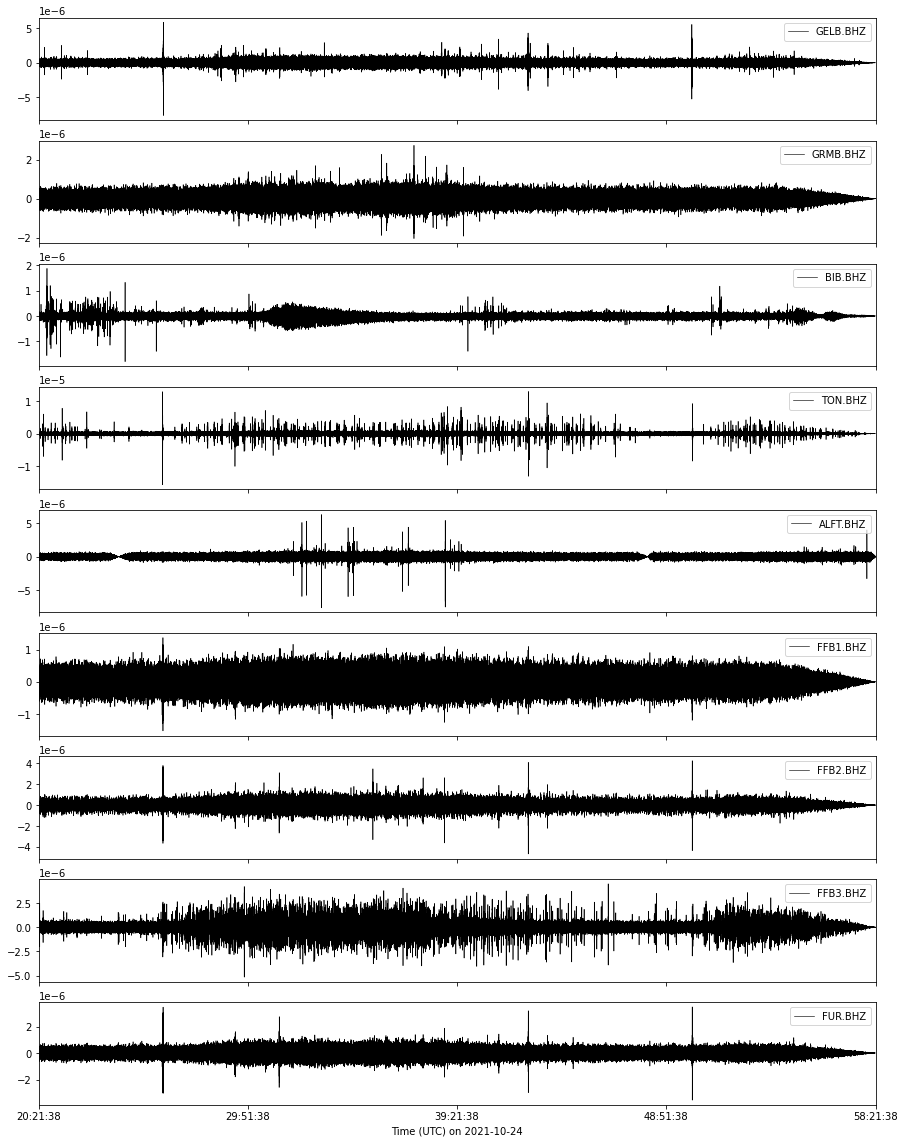

2021-10-24T20:21:38.619852Z 2021-10-26T10:21:38.619852Z
loading BW.GELB..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.GRMB..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.BIB..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.TON..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.ALFT..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.FFB1..BHZ...
loading BW.FFB2..BHZ...
loading BW.FFB3..BHZ...
loading GR.FUR..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
2021-10-24T21:03:00.339016Z 2021-10-26T11:03:00.339016Z
2021-10-24T21:03:00.339016Z 2021-10-26T11:03:00.339016Z
 plotting GELB ...
 plotting GRMB ...
 plotting BIB ...
 plotting TON ...
 plotting ALFT ...
 plotting FFB1 ...


No handles with labels found to put in legend.


nothing to plot
 plotting FFB2 ...


No handles with labels found to put in legend.


nothing to plot
 plotting FFB3 ...


No handles with labels found to put in legend.


nothing to plot
 plotting FUR ...


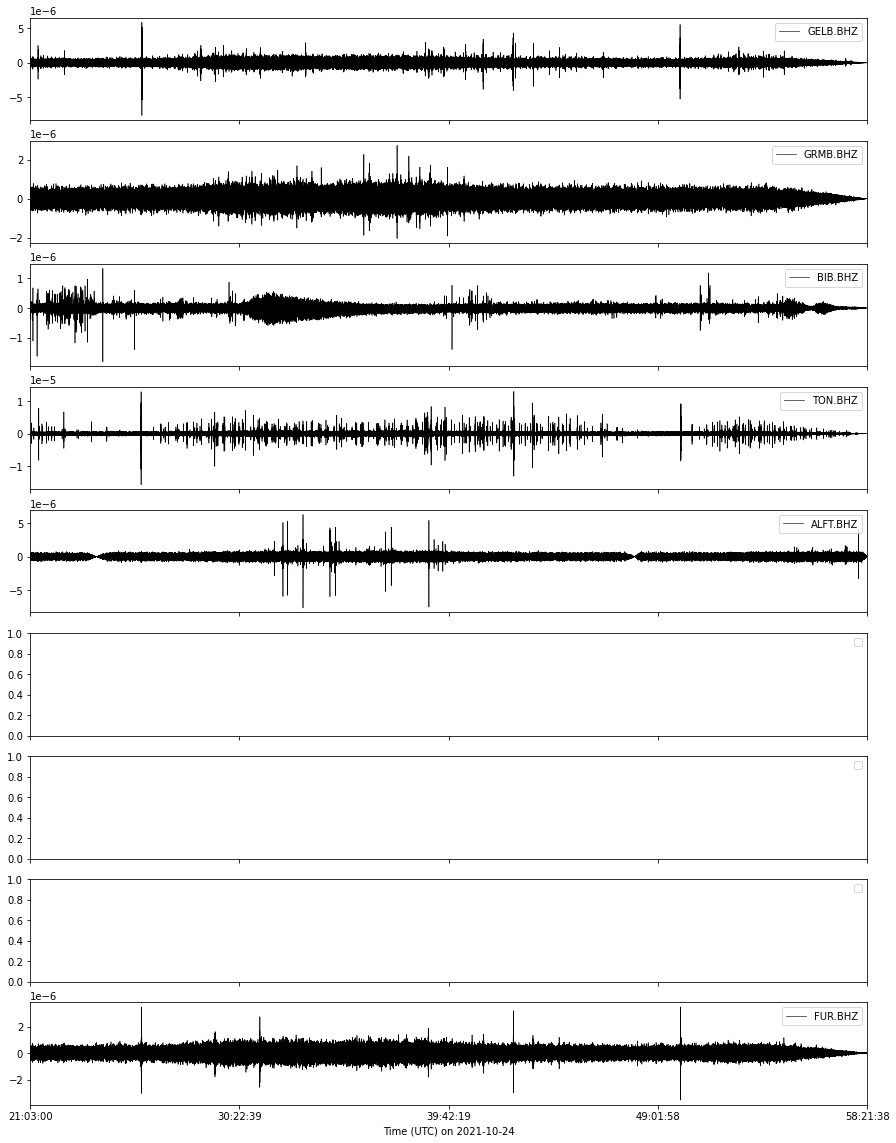

2021-10-24T21:03:00.339016Z 2021-10-26T11:03:00.339016Z
loading BW.GELB..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.GRMB..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.BIB..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.TON..BHZ...
loading BW.ALFT..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.FFB1..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.FFB2..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.FFB3..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading GR.FUR..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
2021-10-24T21:20:08.555237Z 2021-10-26T11:20:08.555237Z
2021-10-24T21:20:08.555237Z 2021-10-26T11:20:08.555237Z
 plotting GELB ...
 plotting GRMB ...
 plotting BIB ...
 plotting TON ...


No handles with labels found to put in legend.


nothing to plot
 plotting ALFT ...
 plotting FFB1 ...


No handles with labels found to put in legend.


nothing to plot
 plotting FFB2 ...


No handles with labels found to put in legend.


nothing to plot
 plotting FFB3 ...


No handles with labels found to put in legend.


nothing to plot
 plotting FUR ...


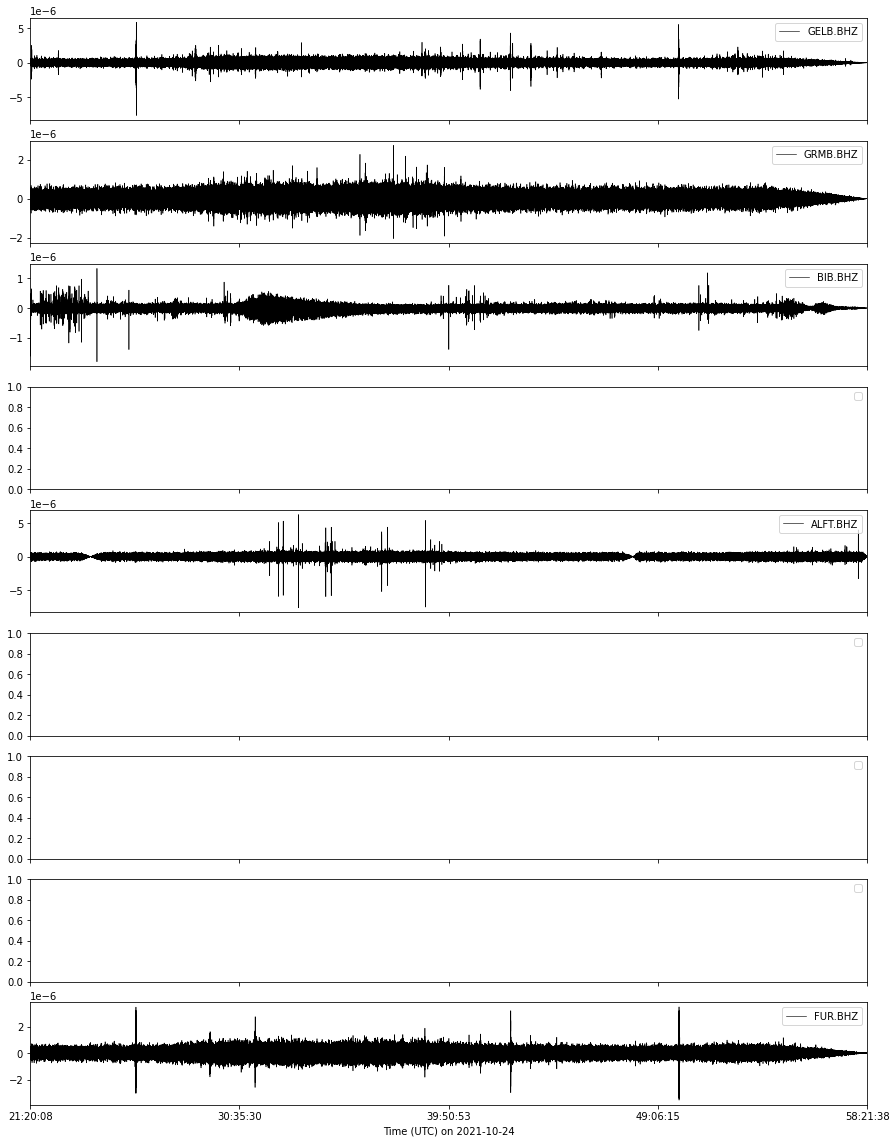

2021-10-24T21:20:08.555237Z 2021-10-26T11:20:08.555237Z
loading BW.GELB..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.GRMB..BHZ...
loading BW.BIB..BHZ...
loading BW.TON..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.ALFT..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.FFB1..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.FFB2..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.FFB3..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading GR.FUR..BHZ...
2021-10-24T21:35:44.610283Z 2021-10-26T11:35:44.610284Z
2021-10-24T21:35:44.610283Z 2021-10-26T11:35:44.610284Z
 plotting GELB ...
 plotting GRMB ...


No handles with labels found to put in legend.


nothing to plot
 plotting BIB ...


No handles with labels found to put in legend.


nothing to plot
 plotting TON ...


No handles with labels found to put in legend.


nothing to plot
 plotting ALFT ...
 plotting FFB1 ...


No handles with labels found to put in legend.


nothing to plot
 plotting FFB2 ...


No handles with labels found to put in legend.


nothing to plot
 plotting FFB3 ...


No handles with labels found to put in legend.


nothing to plot
 plotting FUR ...


No handles with labels found to put in legend.


nothing to plot


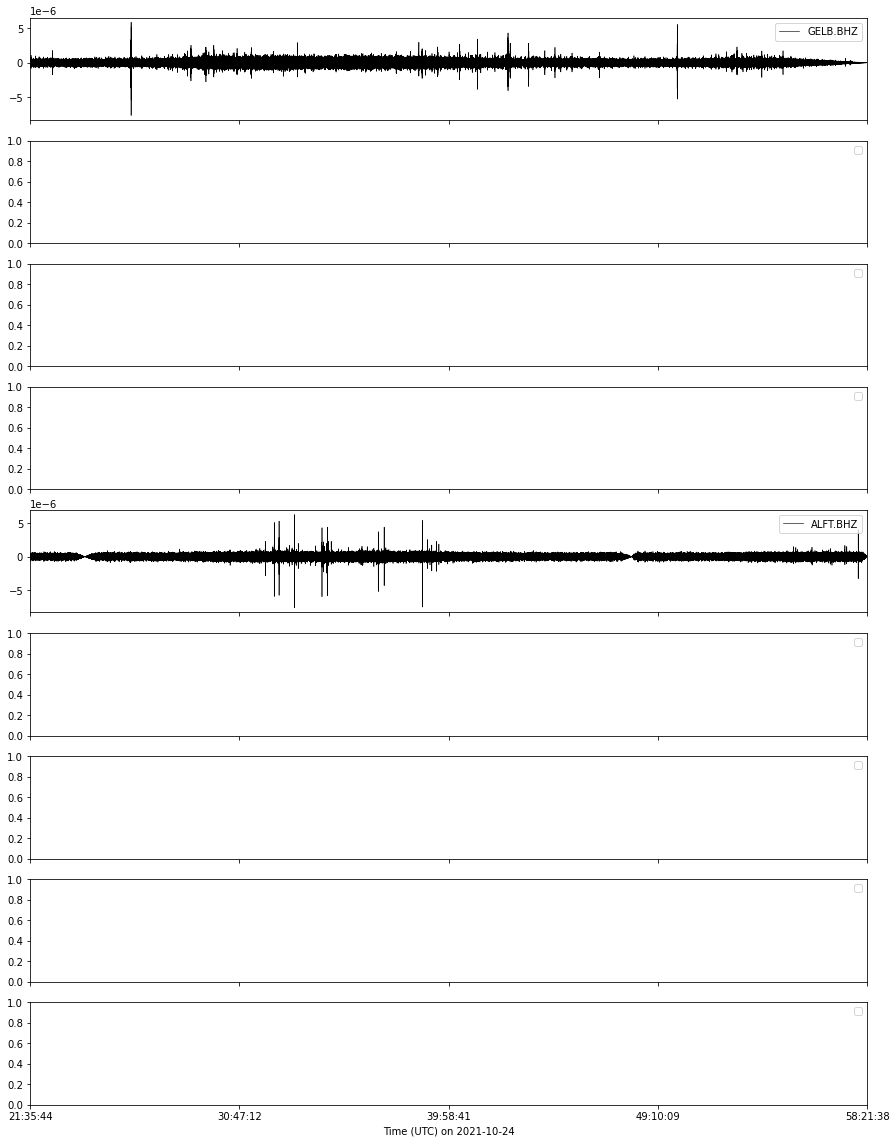

2021-10-24T21:35:44.610283Z 2021-10-26T11:35:44.610284Z
loading BW.GELB..BHZ...
loading BW.GRMB..BHZ...
loading BW.BIB..BHZ...
loading BW.TON..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.ALFT..BHZ...
loading BW.FFB1..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.FFB2..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading BW.FFB3..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
loading GR.FUR..BHZ...
  -> Failed!
  -> Failed!
  -> Failed!
2021-10-24T21:47:04.355826Z 2021-10-26T11:47:04.355826Z
2021-10-24T21:47:04.355826Z 2021-10-26T11:47:04.355826Z
 plotting GELB ...


No handles with labels found to put in legend.


nothing to plot
 plotting GRMB ...


No handles with labels found to put in legend.


nothing to plot
 plotting BIB ...


No handles with labels found to put in legend.


nothing to plot
 plotting TON ...


No handles with labels found to put in legend.


nothing to plot
 plotting ALFT ...


No handles with labels found to put in legend.


nothing to plot
 plotting FFB1 ...


No handles with labels found to put in legend.


nothing to plot
 plotting FFB2 ...


No handles with labels found to put in legend.


nothing to plot
 plotting FFB3 ...


No handles with labels found to put in legend.


nothing to plot
 plotting FUR ...


No handles with labels found to put in legend.


nothing to plot


UnboundLocalError: local variable 'ticks' referenced before assignment

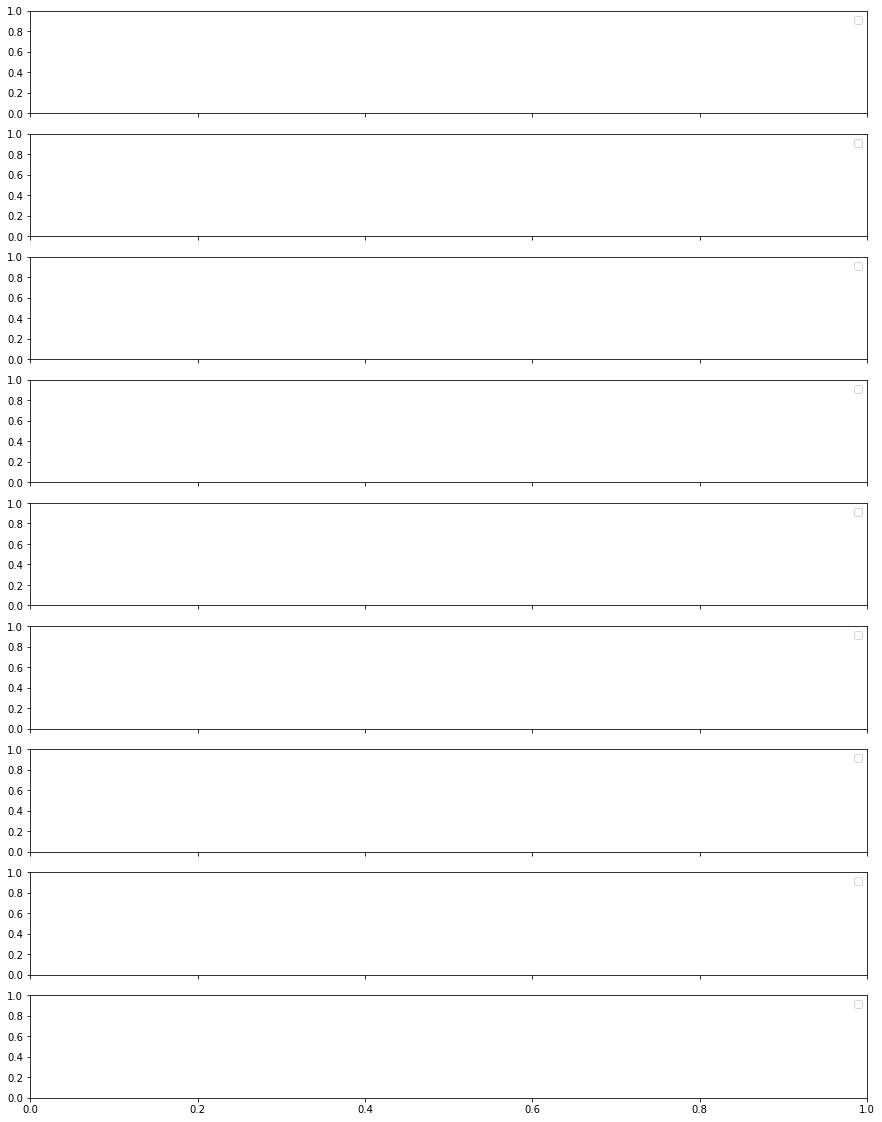

In [21]:
while True: 
    
    sleep(60)
    
    st, config = __update_traces(st, config)
    
    st = __processing(st, config)
    
    fig = __makeplot_array_traces(st, config);
    

In [28]:
st = __processing(st, config)

### Plot Data

 plotting GELB ...


No handles with labels found to put in legend.


nothing to plot
 plotting GRMB ...


No handles with labels found to put in legend.


nothing to plot
 plotting BIB ...


No handles with labels found to put in legend.


nothing to plot
 plotting TON ...


No handles with labels found to put in legend.


nothing to plot
 plotting ALFT ...


No handles with labels found to put in legend.


nothing to plot
 plotting FFB1 ...


No handles with labels found to put in legend.


nothing to plot
 plotting FFB2 ...
nothing to plot


No handles with labels found to put in legend.


 plotting FFB3 ...


No handles with labels found to put in legend.


nothing to plot
 plotting FUR ...


No handles with labels found to put in legend.


nothing to plot


UnboundLocalError: local variable 'ticks' referenced before assignment

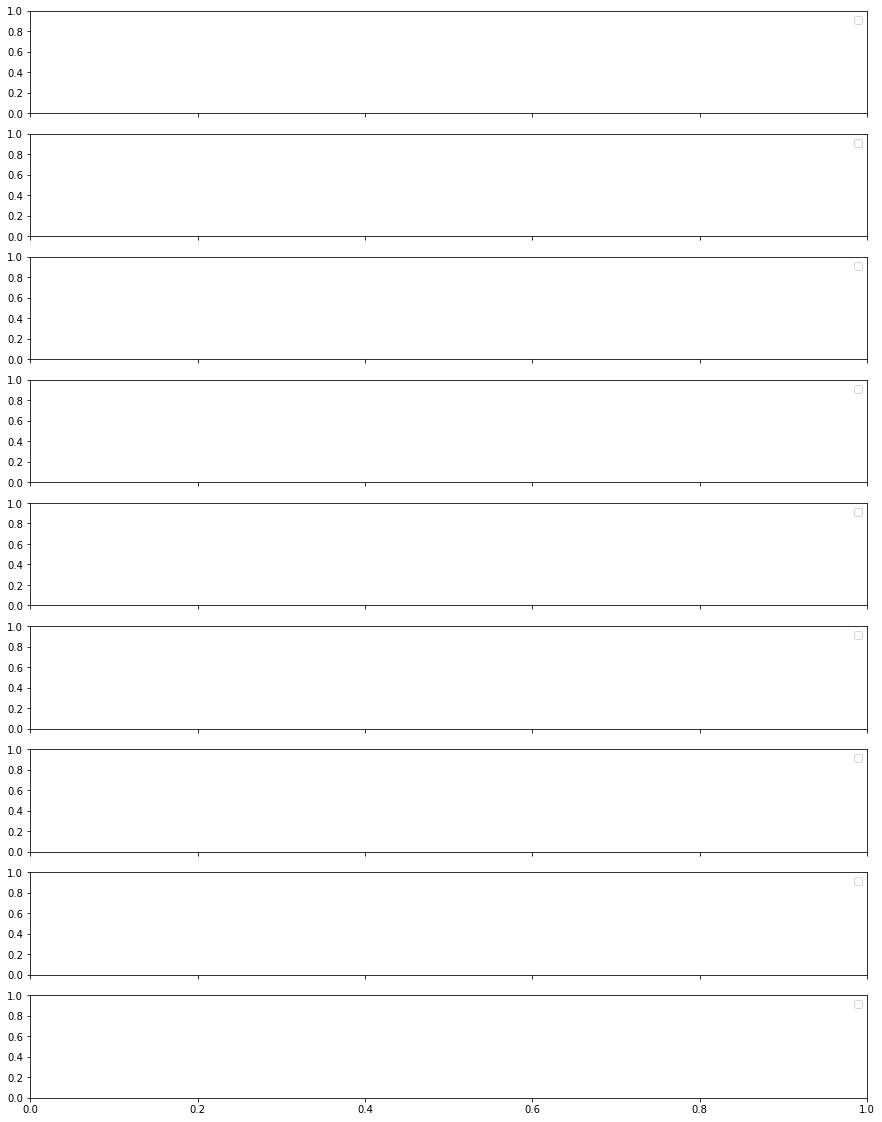

In [29]:
fig = __makeplot_array_traces(st, config);